In [1]:
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))

## Import packages

In [35]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import plotly.express as px
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

In [3]:
#Set variables
img_height = 224
img_width = 224
img_shape = (img_width,img_height,3)
batch_size = 32

## Data import

Load the training/validation images as a TF dataset

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory("images", 
                                                       labels="inferred",
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=123,
                                                       image_size = (img_height,img_width),
                                                       batch_size = batch_size
                                                       )

Found 253 files belonging to 2 classes.
Using 203 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory("images", 
                                                       labels="inferred",
                                                       validation_split=0.2,
                                                       subset="validation",
                                                       seed=123,
                                                       image_size = (img_height,img_width),
                                                       batch_size = batch_size
                                                       )

Found 253 files belonging to 2 classes.
Using 50 files for validation.


We have two class names, no = 0, yes = 1.

In [6]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


Example of the images

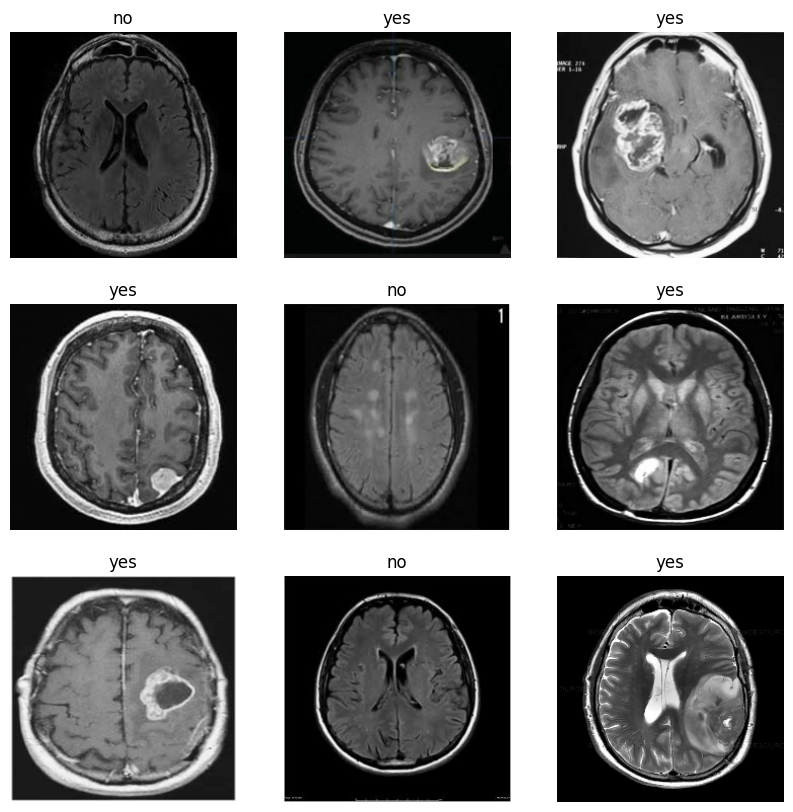

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Create a test dataset from the validation dataset

In [8]:
#Check for cardinality - how many batches of data available in validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)
#Separate 20% (//5) of the validation batches as test batches
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 1
Number of test batches: 1


Use buffered prefetching to load images from disk without having I/O become blocking

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Data augmentation
Given that we have a small amount of training images, we can use data augmentation to introduce sample diversity and reduce the chance of overfitting

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.05,fill_mode="reflect",fill_value=0.0),
])

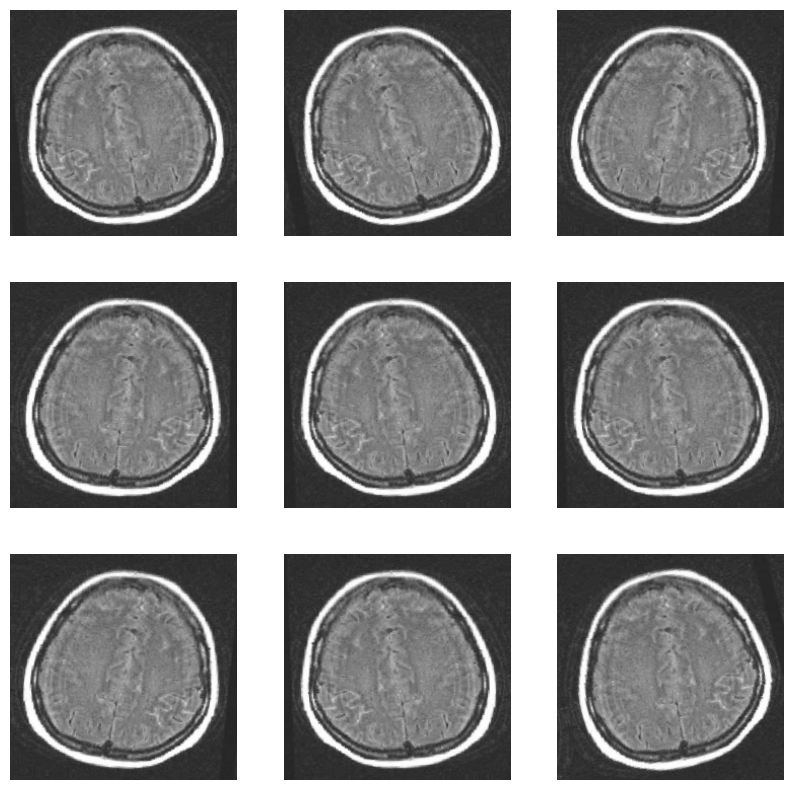

In [12]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model

### Building the model

In [13]:
#normalization_layer = tf.keras.layers.Rescaling(1./255)
preprocess_input = tf.keras.applications.vgg16.preprocess_input

Load the VGG16 architecture with pretrained imagenet weights, set trainable to false to freeze the weights during training

In [14]:

base_model = tf.keras.applications.VGG16(input_shape=img_shape,include_top=False,
                                         weights = "imagenet"
                                         )
base_model.trainable = False

Define the classification head, a global average pooling layer for the 7x7 spatial locations to a single 512 len vector per image

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [16]:
inputs = tf.keras.Input(shape=img_shape)
x=data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(units=256,activation='relu')(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs,outputs)


### Compile the model

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

early_stopping = keras.callbacks.EarlyStopping(patience = 40,
                                               min_delta=0.001,
                                               restore_best_weights=True
                                               )

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

### Train model

In [19]:
#Initial accuracy with only pretrained weights is 0.36
initial_epochs = 200

loss0, accuracy0 = model.evaluate(val_ds)

1/1 [==============================] - 7s 7s/step - loss: 0.7479 - accuracy: 0.5556


In [20]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[early_stopping]
                    )

Epoch 1/200
7/7 [==============================] - 4s 192ms/step - loss: 1.1453 - accuracy: 0.5616 - val_loss: 0.5806 - val_accuracy: 0.7778
Epoch 2/200
7/7 [==============================] - 1s 76ms/step - loss: 1.1027 - accuracy: 0.5665 - val_loss: 0.4740 - val_accuracy: 0.8333
Epoch 3/200
7/7 [==============================] - 1s 67ms/step - loss: 0.9231 - accuracy: 0.6453 - val_loss: 0.5162 - val_accuracy: 0.9444
Epoch 4/200
7/7 [==============================] - 1s 66ms/step - loss: 0.7498 - accuracy: 0.6946 - val_loss: 0.2166 - val_accuracy: 0.9444
Epoch 5/200
7/7 [==============================] - 1s 69ms/step - loss: 0.5361 - accuracy: 0.7635 - val_loss: 0.2426 - val_accuracy: 0.8333
Epoch 6/200
7/7 [==============================] - 1s 66ms/step - loss: 0.6112 - accuracy: 0.7291 - val_loss: 0.4905 - val_accuracy: 0.8333
Epoch 7/200
7/7 [==============================] - 1s 66ms/step - loss: 0.4537 - accuracy: 0.8030 - val_loss: 0.1339 - val_accuracy: 0.9444
Epoch 8/200
7/7 [==

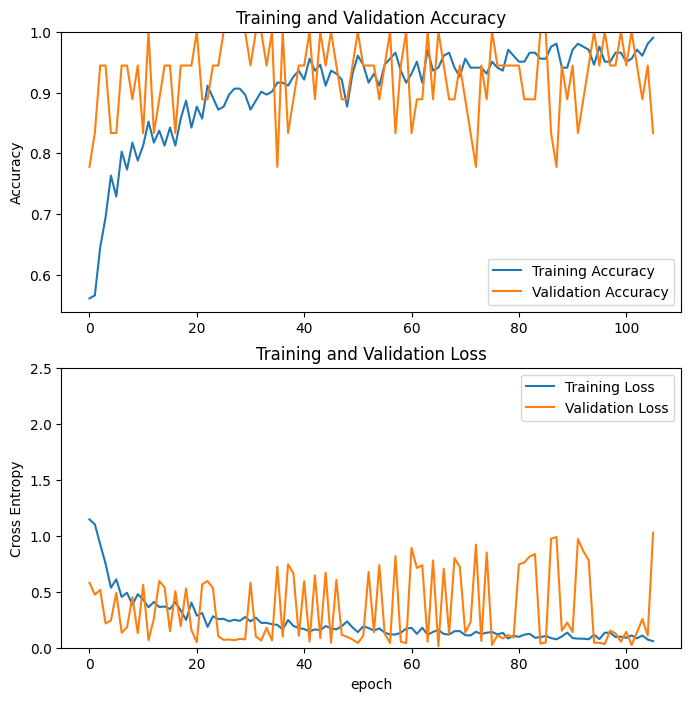

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning the model

In [22]:
#Unfreeze the top layers of the model
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# fine_tune_at = 12
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

Number of layers in the base model:  19


In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [25]:
fine_tune_epochs = 10
if early_stopping.stopped_epoch !=0 :
    total_epochs =  early_stopping.stopped_epoch + fine_tune_epochs
else:
    total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 106/115
7/7 [==============================] - 13s 547ms/step - loss: 0.7956 - accuracy: 0.7882 - val_loss: 0.5030 - val_accuracy: 0.8889
Epoch 107/115
7/7 [==============================] - 1s 163ms/step - loss: 0.1514 - accuracy: 0.9507 - val_loss: 0.5694 - val_accuracy: 0.7222
Epoch 108/115
7/7 [==============================] - 1s 157ms/step - loss: 0.1081 - accuracy: 0.9557 - val_loss: 0.1040 - val_accuracy: 0.9444
Epoch 109/115
7/7 [==============================] - 1s 159ms/step - loss: 0.1012 - accuracy: 0.9655 - val_loss: 0.7368 - val_accuracy: 0.9444
Epoch 110/115
7/7 [==============================] - 1s 159ms/step - loss: 0.1327 - accuracy: 0.9557 - val_loss: 0.6998 - val_accuracy: 0.8889
Epoch 111/115
7/7 [==============================] - 1s 158ms/step - loss: 0.0515 - accuracy: 0.9901 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 112/115
7/7 [==============================] - 1s 159ms/step - loss: 0.0463 - accuracy: 0.9803 - val_loss: 0.8031 - val_accuracy: 0.944

In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

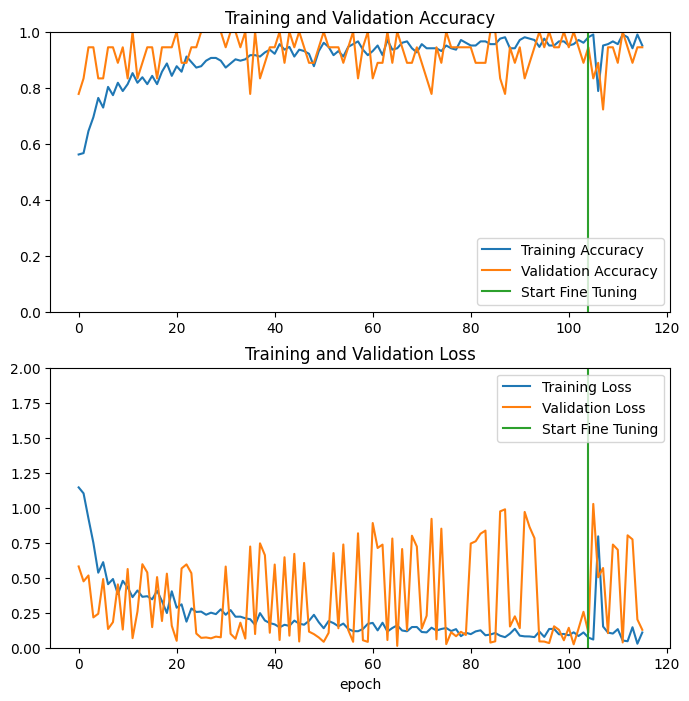

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([total_epochs-fine_tune_epochs-1,total_epochs-fine_tune_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([total_epochs-fine_tune_epochs-1,total_epochs-fine_tune_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation

In [40]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 277ms/step - loss: 0.6642 - accuracy: 0.8125
Test accuracy : 0.8125


Predictions:
 [1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0]
Labels:
 [1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0]


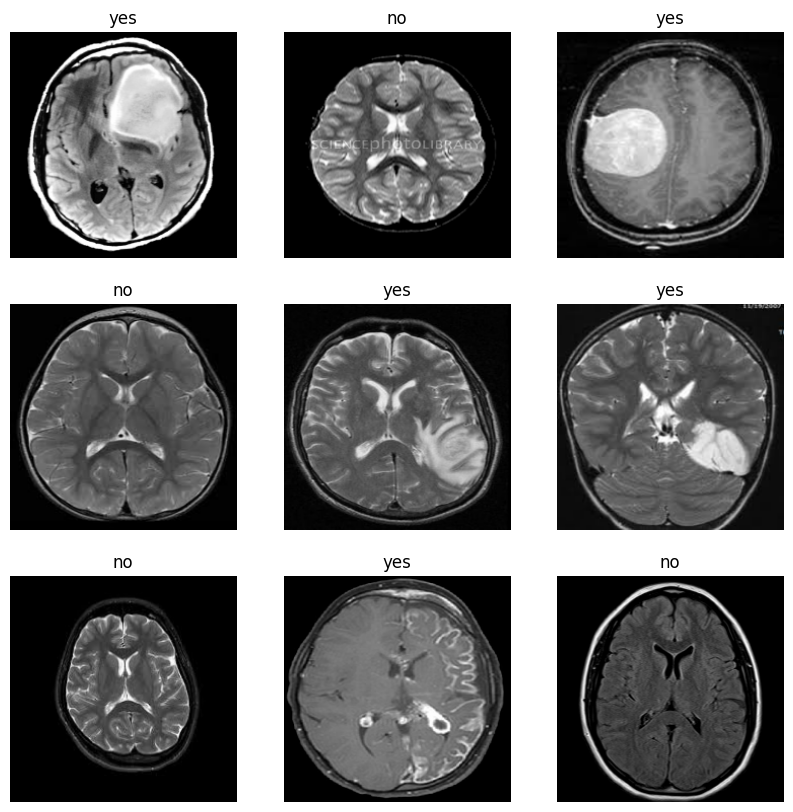

In [29]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

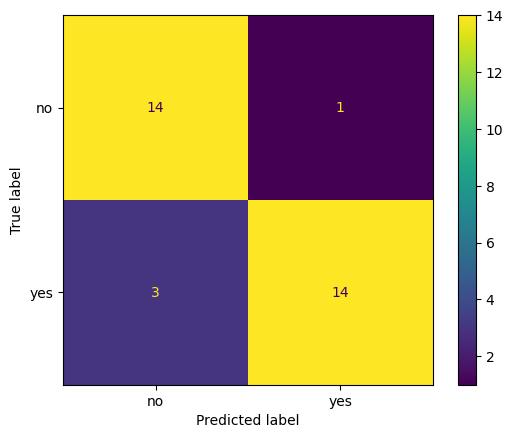

In [38]:
conufsion_mtx = confusion_matrix(label_batch,predictions.numpy())

disp = ConfusionMatrixDisplay(conufsion_mtx,display_labels=class_names)
disp.plot()
plt.show()